# Image Caption Generator for Visually Impaired

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from PIL import Image

from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [4]:
labels = pd.read_csv('./visual.token.txt', header=None, sep='#', names=['image_id', 'Caption'])
labels["Caption"] = labels["Caption"].str.replace('\d+\t', '', regex=True)
labels.head()

,image_id,Caption
0,greensig1.jpg,Green signal please walk .
1,greensig1.jpg,Green signal please walk .
2,greensig1.jpg,Green signal please walk .
3,greensig1.jpg,Green signal please walk .
4,greensig1.jpg,Green signal please walk .


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  8000 non-null   object
 1   Caption   8000 non-null   object
dtypes: object(2)
memory usage: 125.1+ KB


In [6]:
# Feature Extraction
vgg = VGG16()
vgg = Model(inputs=vgg.inputs, outputs=vgg.layers[-2].output)
vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Extract image features
features = {}
BASE_DIR = "./visual_dataset/"
images = os.listdir(BASE_DIR)

for img in images:
    try:
        img_path = os.path.join(BASE_DIR, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        feature = vgg.predict(image, verbose=0)

        image_idx = str(img).split(".")[0]
        features[image_idx] = feature
    except Exception as e:
        print(f"Error processing {img}: {e}")


# Save features
with open("visual_impaired.pkl", "wb") as f:
    pickle.dump(features, f)

c:\Users\kangj\OneDrive\Desktop\Twitter Caption Generator\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [7]:
# Preprocess Twitter captions
class Preprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords = set(stopwords.words("english"))

    def remove_username(self, tweet):
        return re.sub(r"@(\w+)", "", tweet)
    
    def remove_punctuations(self, tweet):
        puncs = [".", ",", "!", "?", ":", ";", "-", "_", "(", ")", "[", "]", "{", "}", "<", ">", "/", "\\", "|", "#", "@", "$", "%", "^", "&", "*", "+", "=", "~", "`", "RT"]
        for punc in puncs:
            tweet = tweet.replace(punc, "")
        return tweet

    def remove_stopwords(self, tweet):
        stop_words = set(stopwords.words('english'))
        filtered_tweets = [t for t in tweet.split(" ") if t.lower() not in stop_words]
        return " ".join(filtered_tweets).strip()
    
    def lemmatize(self, tweet):
        lemmatized = [self.lemmatizer.lemmatize(t) for t in tweet.split(" ")]
        return " ".join(lemmatized)
    
    def stem_words(self, tweet):
        stemmer = PorterStemmer()
        stemmed = [stemmer.stem(t) for t in tweet.split(" ")]
        return " ".join(stemmed)

In [8]:
# Apply preprocessing
preprocessor = Preprocessor()
labels["Caption"] = labels["Caption"].fillna("").astype(str)
labels["Caption"] = labels["Caption"].apply(preprocessor.remove_username)
labels["Caption"] = labels["Caption"].apply(preprocessor.remove_punctuations)
labels["Caption"] = labels["Caption"].apply(preprocessor.remove_stopwords)
labels["Caption"] = labels["Caption"].apply(preprocessor.lemmatize)

# Add start/end tokens
labels["Caption"] = labels["Caption"].apply(lambda x: "<start> " + x + " <end>")

In [9]:
labels

,image_id,Caption
0,greensig1.jpg,<start> Green signal please walk <end>
1,greensig1.jpg,<start> Green signal please walk <end>
2,greensig1.jpg,<start> Green signal please walk <end>
3,greensig1.jpg,<start> Green signal please walk <end>
4,greensig1.jpg,<start> Green signal please walk <end>
...,...,...
7995,playing50.jpg,<start> Kids playing park <end>
7996,playing50.jpg,<start> Kids sitting park <end>
7997,playing50.jpg,<start> Kids sitting garden <end>
7998,playing50.jpg,<start> Group kid sitting park <end>


In [12]:
# Load image features
with open("visual_impaired.pkl", "rb") as f:
    image_features = pickle.load(f)

In [13]:
MAX_LENGTH = max(len(caption.split()) for caption in labels["Caption"])

In [14]:
# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(labels["Caption"].values)
vocab_size = len(tokenizer.word_index) + 1

print("Vocab size: ", vocab_size)

Vocab size:  119


In [ ]:
# 
def generate_data(keys, labels, max_length, tokenizer, vocab_size, batch_size=32):
    """
    Organize the data into image features, input sequence features and the label (output sequence).

    features - image features
    labels - caption dataframe
    max)_length - maximum length of the caption
    tokenizer - tokenizer object
    vocab_size - total # of classes the model can predict
    """
    img_features, i_sequence, o_sequence = list(), list(), list()
    counter = 0
    while 1:
        for key in keys:
            counter +=1
            image_feature = image_features[key][0] #(4096,)

            labels_per_image = labels[labels["image_id"] == f"{key}.jpg"]["Caption"].values
            
            for label in labels_per_image:

                label_split = tokenizer.texts_to_sequences([label])[0]
                for i in range(1,len(label_split)):
                    prev, next = label_split[:i], label_split[i]
                    in_seq = pad_sequences([prev], maxlen=max_length, padding='post')[0].astype('int32')
                    
                    img_features.append(image_feature)
                    i_sequence.append(in_seq)
                    o_sequence.append(next)

            if counter == batch_size:
                yield (np.array(img_features, dtype='float32'), np.array(i_sequence, dtype='int32')), np.array(o_sequence, dtype='int32')
                img_features, i_sequence, o_sequence = list(), list(), list()
                counter = 0
                    
generate_data(image_features, labels, max_length=MAX_LENGTH, tokenizer=tokenizer, vocab_size=vocab_size)

<generator object generate_data at 0x0000020117425240>

In [16]:
def pretrained_embedding(glove_file):
    features = {}
    with open(glove_file, "r", encoding="utf-8") as f:
        for line in f:
            word = line.split()[0]
            vec = np.array(line.split()[1:], dtype="float32")

            features[word] = vec

        return features
word_to_vec = pretrained_embedding("glove.6B.50d.txt")

In [17]:
def pretrained_embedding_layer(vocab_size):
    embedding_matrix = np.zeros((vocab_size, 50))

    for word, i in word_to_vec.items():
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            embedding_matrix[idx] = word_to_vec[word]
        
    embedding_layer = Embedding(vocab_size, 50, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

pretrained_embedding = pretrained_embedding_layer(len(tokenizer.word_index)+1)

In [18]:
from tensorflow.keras.layers import Bidirectional
# Model definition
def caption_generator_model(vocab_size):
    image_input = Input(shape=(4096,))
    second_last_layer = Dropout(0.5)(image_input) # trainable 2nd last layer
    last_layer = Dense(256, activation='relu')(second_last_layer) # trainable last layer

    text_input = Input(shape=(MAX_LENGTH,))

    embedding = pretrained_embedding(text_input) 

    t = Dropout(0.5)(embedding)
    t = Bidirectional(LSTM(128))(t) 

    concat = add([last_layer, t])

    res = Dense(128, activation='relu')(concat)
    res = Dense(vocab_size, activation='softmax')(res)

    model = Model(inputs=[image_input, text_input], outputs=res)

    return model

model = caption_generator_model(vocab_size=vocab_size)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 50)    │      5,950 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 50)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    183,296 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 119)       │     15,351 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,286,325 (4.91 MB)

 Trainable params: 1,280,375 (4.88 MB)

 Non-trainable params: 5,950 (23.24 KB)

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [20]:
steps = len(image_features) // 32
# creating a directory named models to save our models
import tensorflow as tf

output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype='float32'),  # image features
        tf.TensorSpec(shape=(None, MAX_LENGTH), dtype='int32')  # input sequence
    ),
    tf.TensorSpec(shape=(None,), dtype='int32')  # output sequence
)

generator = lambda: generate_data(list(image_features.keys()), labels, max_length=MAX_LENGTH, tokenizer=tokenizer, vocab_size=vocab_size)
dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
model.fit(dataset, steps_per_epoch= steps, epochs=20, verbose=2)

Epoch 1/20
50/50 - 13s - 259ms/step - loss: 4.5103
Epoch 2/20
50/50 - 7s - 131ms/step - loss: 3.8925
Epoch 3/20
50/50 - 7s - 132ms/step - loss: 3.5292
Epoch 4/20
50/50 - 7s - 137ms/step - loss: 2.9996
Epoch 5/20
50/50 - 8s - 158ms/step - loss: 2.7478
Epoch 6/20
50/50 - 7s - 147ms/step - loss: 2.4402
Epoch 7/20
50/50 - 7s - 146ms/step - loss: 2.2740
Epoch 8/20
50/50 - 7s - 145ms/step - loss: 2.0615
Epoch 9/20
50/50 - 7s - 149ms/step - loss: 1.9146
Epoch 10/20
50/50 - 7s - 133ms/step - loss: 1.7160
Epoch 11/20
50/50 - 7s - 137ms/step - loss: 1.4961
Epoch 12/20
50/50 - 7s - 133ms/step - loss: 1.3959
Epoch 13/20
50/50 - 7s - 134ms/step - loss: 1.3065
Epoch 14/20
50/50 - 7s - 134ms/step - loss: 1.2271
Epoch 15/20
50/50 - 7s - 135ms/step - loss: 1.1228
Epoch 16/20
50/50 - 7s - 136ms/step - loss: 1.0290
Epoch 17/20
50/50 - 7s - 136ms/step - loss: 1.0476
Epoch 18/20
50/50 - 7s - 135ms/step - loss: 0.9374
Epoch 19/20
50/50 - 7s - 133ms/step - loss: 0.8394
Epoch 20/20
50/50 - 7s - 136ms/step - l

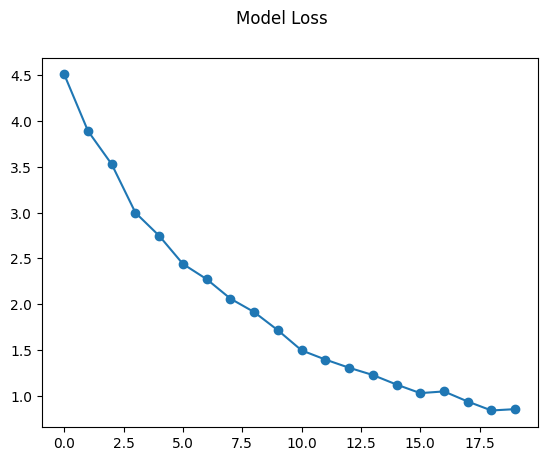

In [22]:
# Plot loss
plt.plot(model.history.history['loss'], marker='o')
plt.suptitle("Model Loss")
plt.show()

In [187]:
# Save model
model.save("visual_impaired_captioning_model.keras")

In [41]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


TEST_PATH = "Test/"
def write_caption(image_name, reference):
    caption = "<start>"
    
    image_path = os.path.join(TEST_PATH, image_name)
    
    image = Image.open(image_path).resize((224, 224))
    for_display = image
    
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)   
    image = preprocess_input(image)

    feature = vgg.predict(image, verbose=0)

    while True:
        tokenized = tokenizer.texts_to_sequences([caption])[0]

        in_seq = pad_sequences([tokenized], maxlen=MAX_LENGTH, padding='post')[0].astype('int32')
        in_seq = np.expand_dims(in_seq, axis=0)
        pred = model.predict([feature, in_seq], verbose=0)
        
        next_word = np.argmax(pred[0])

        caption += " " + tokenizer.index_word[next_word]
        if tokenizer.index_word[next_word] == "end":
            break
        
    # Calculate BLEU score
    caption = caption[:-1].split(" ")[1:-1]

    score = sentence_bleu(reference, caption, weights=(0.75,0.25,0,0))
    plt.imshow(for_display)
    print(f"BLEU score: {score:.4f}")
    print(caption)

BLEU score: 0.4518
['red', 'signal', 'dont', 'walk']


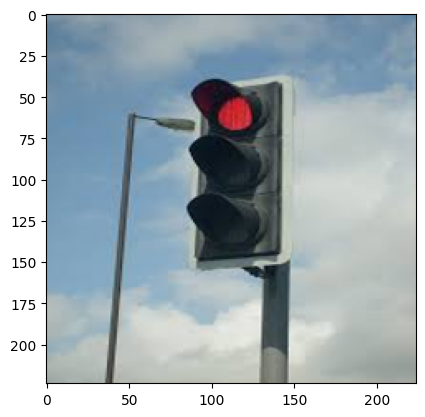

In [42]:
references = [
    ['there', 'is', 'a', 'red', 'light'],
    ['red', 'signal', 'please', 'stop'],
    ['don\'t', 'cross', 'the', 'red', 'light']
]

write_caption("red_light.jpg", references)

BLEU score: 0.9036
['green', 'signal', 'please', 'walk']


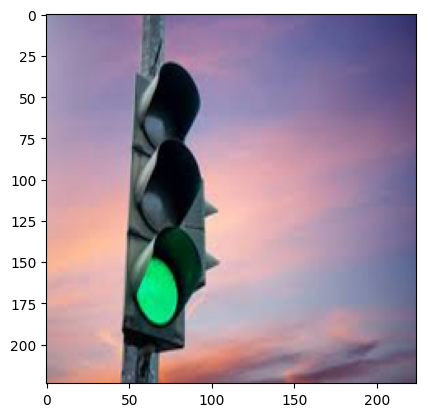

In [43]:
references = [
    ['there', 'is', 'a', 'green', 'signal'],
    ['green','signal', 'ahead'],
    ['please', 'walk', 'signal', 'green', 'light']
]

write_caption("green_light.jpg", references)

BLEU score: 0.4821
['please', 'watchful', 'construction', 'ahead', 'street']


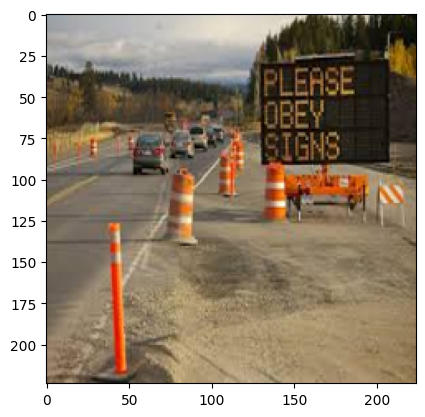

In [44]:
references = [
    ['construction', 'sign', 'ahead'],
    ['please', 'mind', 'construction', 'ahead'],
    ['please', 'obey', 'signs', 'construction']
]

write_caption("construction.jpg", references)